In [1]:
!pip install lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [8]:
#@title Load station and meteorological model. Save fusion file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import pickle


def transform_value_l(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

def transform_value_m(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CM{first_decimal}'

def transform_to_nearest_odd(arr):
    # Make a copy of the input array
    arr_copy = arr.copy()

    # Find even numbers
    even_indices = arr_copy % 2 == 0

    # Increment even numbers to the nearest odd number
    arr_copy[even_indices] += 1

    return arr_copy.astype(str)

def custom_round(value):
    if value > 9001:
        return str(9999)
    elif value < 1000:
        return str(500)
    else:
        return str(round(value / 1000) * 1000)



pd.options.display.max_rows = 999

station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/LESTY2018Y2022.csv",
                          parse_dates=["time"]).dropna().set_index("time")

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2022.csv",parse_dates=["time"])
df_all = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#add time variables
df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#algorithms directory
algo_dir = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/algorithms/"

#wind direction to words
df_all["dir0_l"] = result = ["0" + c if len(c) == 2 else ("00" + c if len(c) == 1 else c) for c in (round(df_all["dir0"],-1).astype(int).astype(str))]
all = round(df_all["mod0"] * 1.94384, 0).astype(int).values
list_mod0 = ["0" + str(c) if len(c) == 1 else str(c) for c in transform_to_nearest_odd(all)]
df_all["wind"]=df_all["dir0_l"]+list_mod0+"kt"

#visibility words
"""
interval = pd.IntervalIndex.from_tuples([(-1.5, 20000),(20000,30000)])
labels = ['vi20d', 'vi20u']
df_all["visibility0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["visibility0_l","visibility0"]].sample(100)

# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_all['visibility0_l'] = ((a * df_all['visibility0'] + b).round().astype(int)).apply(custom_round)
"""
alg = pickle.load(open(algo_dir+"llmvis_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["vis_ml"] =  alg["pipe"].predict(model_x_var)


#rh in words
interval = pd.IntervalIndex.from_tuples([(-1.5, .80),(.80,100)])
labels = ['rhd80', 'rhu80']
df_all["rh0_l"] = pd.cut(df_all["rh0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["rh0_l","rh0"]].sample(100)


#wx words
alg = pickle.load(open(algo_dir+"llmwx_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["wx_ml"] =  alg["pipe"].predict(model_x_var)

"""
alg = pickle.load(open(algo_dir+"llmprec_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["prec_ml"] =  alg["pipe"].predict(model_x_var)

interval = pd.IntervalIndex.from_tuples([(-1.5, 0.1),(.1,180)])
labels = ['prec0n', 'prec0y']
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["prec0_l","prec0"]].sample(100)
"""

#cfl words
#df_all['cfl0_l'] = round(df_all["cfl0"],1).apply(transform_value_l)
alg = pickle.load(open(algo_dir+"llmskyc1_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["cfl_ml"] =  alg["pipe"].predict(model_x_var)

#clouds height
alg = pickle.load(open(algo_dir+"llmskyl1_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["cfll1_ml"] =  alg["pipe"].predict(model_x_var)


#cfm words
#df_all['cfm0_l'] = round(df_all["cfm0"],1).apply(transform_value_m)
alg = pickle.load(open(algo_dir+"llmskyc2_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["cfm_ml"] =  alg["pipe"].predict(model_x_var)

#temp words
alg = pickle.load(open(algo_dir+"temp_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["temp"] =  alg["pipe"].predict(model_x_var)
df_all["temp_ml"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp"]-273.16,0).astype(int).astype(str)]
df_all["temp0_l"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp0"]-273.16,0).astype(int).astype(str)]

#temp dew words
alg = pickle.load(open(algo_dir+"llmtempd_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["tempd"] =  alg["pipe"].predict(model_x_var)
df_all["tempd_ml"] = ["0" + c if len(c) == 1 else c for c in round(df_all["tempd"]-273.16,0).astype(int).astype(str)]


#mslp words
alg = pickle.load(open(algo_dir+"pres_LEST_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["pres"] =  alg["pipe"].predict(model_x_var)
pres = round(df_all["pres"],0).astype(int).astype(str)
df_all["mslp_ml"] =[ "q"+p if len(p)==4 else "q0"+p for p in pres]

#time variables
df_all['hour'] = 'H' + df_all.index.hour.astype(str)
df_all['month'] = 'M' + df_all.index.month.astype(str)

#select variable met model
df_all["model_seed"]= df_all["wind"]+" "+df_all["vis_ml"]+" "+df_all["wx_ml"]+" "+df_all["cfl_ml"]+df_all["cfll1_ml"]+" "+df_all["cfm_ml"]+" "+df_all["temp_ml"]+ " "+df_all["tempd_ml"]+" "+df_all["mslp_ml"]


station_raw["metar_o"] = station_raw["metar_o"].astype(str)
station_raw["metar_o"] = station_raw["metar_o"].str.split().apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')

result = pd.concat([station_raw,df_all["model_seed"]],axis=1).dropna()
result["fusion"]= result["model_seed"]+" "+result["metar_o"]

#save fusion
path_result = "/content/drive/MyDrive/Colab Notebooks/gpt/i+d/fusionml.csv"
result["fusion"].to_csv(path_result)
result["fusion"].sample(100).values

array(['03009kt 9999 WM FEWNClD M 10 09 q1033 05008KT 010V100 CAVOK 09/08 Q1033 NOSIG',
       '24011kt 9999 RA SCT010 SCT 10 07 q1016 24003KT 200V310 7000 -RA FEW008 SCT020 BKN035 09/08 Q1015 TEMPO 3000 -RA BKN012',
       '25017kt 9999 WM FEW015 BKN 13 10 q1011 27009KT 230V320 7000 SCT005 BKN010 FEW020TCU 12/11 Q1010 TEMPO 3000 SHRA SCT025TCU',
       '03005kt 9999 WM MNClD M 18 15 q1024 VRB02KT 9999 FEW015 17/15 Q1024 NOSIG',
       '22003kt 9999 WM FEW050 M 08 06 q1026 19003KT 9999 FEW048 09/05 Q1027 NOSIG',
       '17001kt 9999 WM MNClD M 16 07 q1018 00000KT CAVOK 16/05 Q1018 NOSIG',
       '05015kt 9999 WM FEW040 M 19 12 q1022 06011KT 020V100 9999 SCT042 20/11 Q1022 NOSIG',
       '23009kt 9999 WM MNClD M 16 03 q1020 24003KT 150V300 CAVOK 17/03 Q1019 NOSIG',
       '34017kt 9999 WM FEW015 SCT 05 03 q1010 34015KT 300V020 9999 SCT020 SCT039 06/02 Q1011 TEMPO 2000 RA BKN005',
       '09009kt 9999 WM M050 M 12 08 q1010 VRB01KT CAVOK 10/09 Q1010 NOSIG',
       '05003kt 9999 FG FEW015 

In [4]:
#@title Pressure
df_p = pd.concat([df_all[["mslp0","pres"]].astype(int),station_raw["mslp_o"].astype(int)],axis=1).dropna()
df_p["dif_metmodel"]=df_p["mslp0"]/100-df_p["mslp_o"]
df_p["dif_ml"]=df_p["pres"]-df_p["mslp_o"]
df_p.describe()



,mslp0,pres,mslp_o,dif_metmodel,dif_ml
count,41600.000000,41600.000000,41600.000000,41600.000000,41600.000000
mean,101840.514135,1017.756058,1018.255072,0.150069,-0.499014
std,743.846300,7.164042,7.192809,0.958452,0.634057
min,96981.000000,975.000000,975.000000,-7.660000,-4.000000
25%,101466.000000,1014.000000,1015.000000,-0.500000,-1.000000
50%,101869.000000,1018.000000,1019.000000,0.110000,0.000000
75%,102287.000000,1022.000000,1023.000000,0.760000,0.000000
max,103773.000000,1035.000000,1037.000000,7.160000,4.000000


In [5]:
#@title Temperature

df_t = pd.concat([df_all[["temp0_l","temp_ml"]].astype(int),round(station_raw["temp_o"]-273.16,0).astype(int)],axis=1).dropna()
df_t["dif_metmodel"]=df_t["temp0_l"]-df_t["temp_o"]
df_t["dif_ml"]=df_t["temp_ml"]-df_t["temp_o"]
df_t.describe()

,temp0_l,temp_ml,temp_o,dif_metmodel,dif_ml
count,41600.000000,41600.000000,41600.000000,41600.000000,41600.000000
mean,12.739327,12.966659,13.128654,-0.389327,-0.161995
std,5.838976,5.563980,5.673436,1.699585,1.022962
min,-2.000000,-3.000000,-4.000000,-8.000000,-6.000000
25%,9.000000,9.000000,9.000000,-1.000000,-1.000000
50%,12.000000,12.000000,13.000000,0.000000,0.000000
75%,16.000000,16.000000,16.000000,1.000000,0.000000
max,38.000000,36.000000,37.000000,9.000000,6.000000


In [6]:
#@title dew Temperature

df_tw = pd.concat([df_all["tempd_ml"].astype(int),round(station_raw["tempd_o"]-273.16,0).astype(int)],axis=1).dropna()

df_tw["dif_ml"]=df_tw["tempd_ml"]-df_tw["tempd_o"]
df_tw.describe()

,tempd_ml,tempd_o,dif_ml
count,41600.000000,41600.000000,41600.000000
mean,9.638510,9.796611,-0.158101
std,4.440871,4.596950,1.103909
min,-5.000000,-8.000000,-6.000000
25%,6.000000,7.000000,-1.000000
50%,10.000000,10.000000,0.000000
75%,13.000000,13.000000,0.000000
max,23.000000,26.000000,8.000000


,cfh0,cfl0,cfm0,visibility_o
cfh0,1.000000,0.186239,0.484204,-0.172861
cfl0,0.186239,1.000000,0.400573,-0.444849
cfm0,0.484204,0.400573,1.000000,-0.159248
visibility_o,-0.172861,-0.444849,-0.159248,1.000000


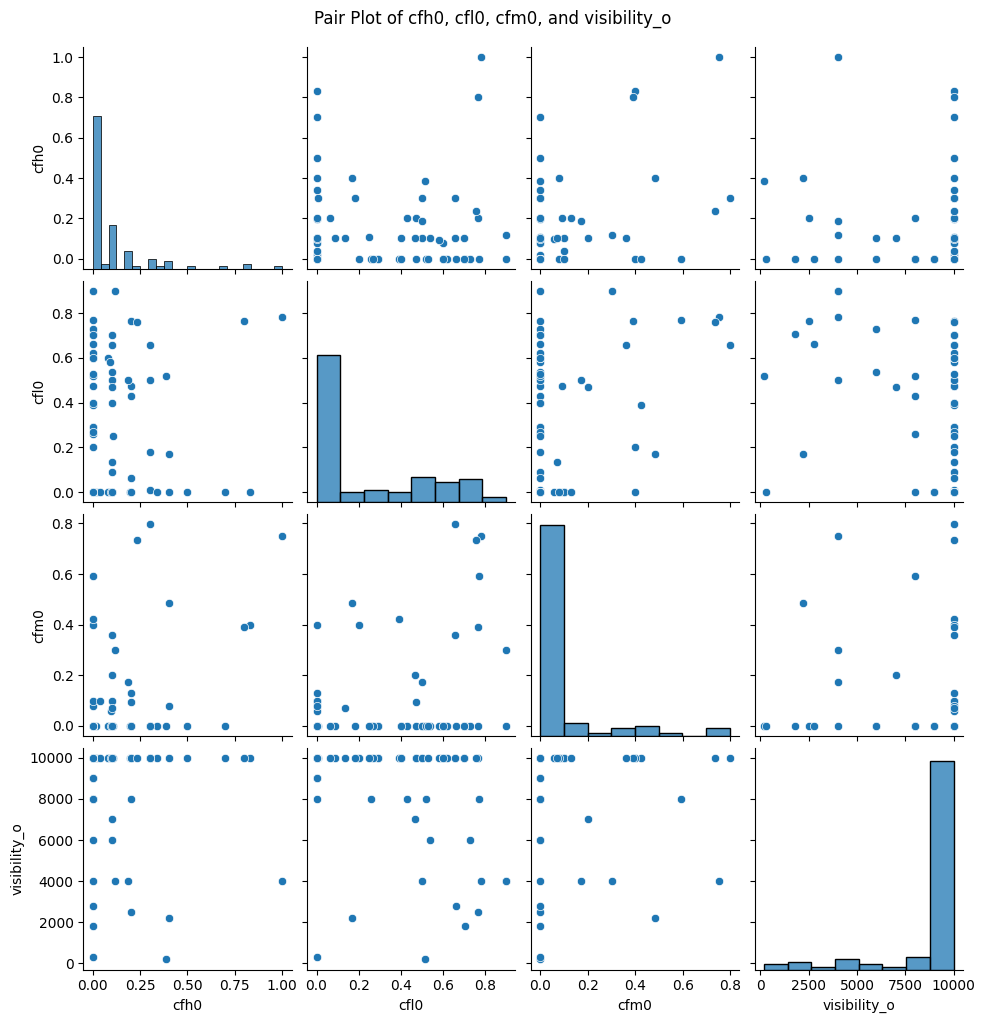

In [7]:
#@title Clouds
df_clo = pd.concat([df_all[['cfh0', 'cfl0', 'cfm0']],station_raw['visibility_o']],axis=1).dropna().sample(100)
display(df_clo.corr())
sns.pairplot(df_clo)
plt.suptitle('Pair Plot of cfh0, cfl0, cfm0, and visibility_o', y=1.02)
plt.show()


In [ ]:
def transform_value(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

df_all["cfl0"] = round(df_all["cfl0"],1)
df_all['cfl0_l'] = df_all['cfl0'].apply(transform_value)
df_all[["cfl0","cfl0_l"]]

,cfl0,cfl0_l
time,,
2018-01-01 01:00:00,0.0,CL0
2018-01-01 02:00:00,0.1,CL1
2018-01-01 03:00:00,0.1,CL1
2018-01-01 04:00:00,0.4,CL4
2018-01-01 05:00:00,0.3,CL3
...,...,...
2022-12-31 19:00:00,0.5,CL5
2022-12-31 20:00:00,0.5,CL5
2022-12-31 21:00:00,0.4,CL4


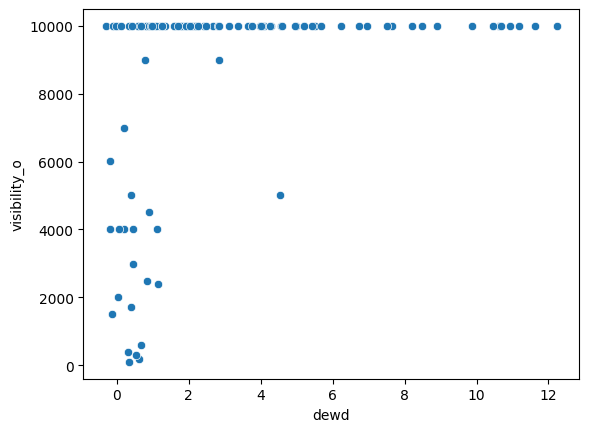

In [ ]:
#@title Temperature minus temperature dew point
#dew_temperature = dry_temperature - (100 - relative_humidity) / 5
df_all["dewd"] = df_all["temp0"]-round(df_all["temp0"]- (100 - df_all["rh0"]*100) / 5,0)
vis = pd.concat([df_all["dewd"],station_raw["visibility_o"]],axis=1).dropna()
vis.describe()
sns.scatterplot(vis.sample(100),x="dewd",y="visibility_o");

In [ ]:
vis.describe()

,dewd,visibility_o
count,41600.000000,41600.000000
mean,3.157556,8854.889183
std,3.190797,2451.469949
min,-0.499939,48.000000
25%,0.580566,9994.000000
50%,2.056458,9994.000000
75%,5.053375,9994.000000
max,14.937744,9994.000000


In [ ]:
def get_nth_word(text, n):
    # Split the text into words
    words = text.split()
    # Check if the index n is valid
    if n <= 0 or n > len(words):
        return "Invalid index"
    # Get the nth word (indexing starts from 1)
    return words[n - 1]


result["wind_metar"] = [get_nth_word(text, 7) for text in result.fusion]
result["wind_metar"] = result["wind_metar"].astype(str)
result["wind_metar"].value_counts()

wind_metar
VRB02KT       2925
VRB01KT       1894
00000KT       1653
VRB03KT        415
VRB04KT        268
              ... 
25008G19KT       1
03017G28KT       1
04018G30KT       1
05015G27KT       1
21022G38KT       1
Name: count, Length: 1592, dtype: int64

In [ ]:
pd.options.display.max_rows = 999
win = pd.concat([result["wind_metar"],df_all],axis=1).dropna()
win["g"] = ["y" if 'G' in t else "n" for t in win.wind_metar]
win["g"].value_counts(normalize=True)

g
n    0.934904
y    0.065096
Name: proportion, dtype: float64

In [ ]:
win["dif_int"] = win["wind_gust0"]-win["mod0"]
win[win.g=="y"][["mod0","wind_gust0","wind_metar"]].sample(100)

,mod0,wind_gust0,wind_metar
time,,,
2019-11-22 12:00:00,12.261683,18.938030,26009G23KT
2022-12-18 21:00:00,14.252416,22.831747,20021G32KT
2020-07-14 19:00:00,8.070247,12.072361,02015G25KT
2021-01-24 12:00:00,8.522390,13.431847,26011G21KT
2020-11-15 09:00:00,10.541652,16.055607,24015G27KT
2021-01-21 11:00:00,12.389274,18.031359,26015G28KT
2020-11-14 21:00:00,10.162958,15.509943,23012G22KT
2019-11-14 17:00:00,13.744637,20.521610,33013G23KT
2021-10-02 11:00:00,8.936397,16.080908,24013G27KT


In [ ]:
win[win.g=="y"]["wind_gust0"].describe()

count    2708.000000
mean       15.374798
std         4.341556
min         0.360282
25%        12.522136
50%        15.357202
75%        18.211459
max        29.232828
Name: wind_gust0, dtype: float64

In [ ]:
win[win.wind_gust0>11]["g"].value_counts()

g
n    5254
y    2299
Name: count, dtype: int64

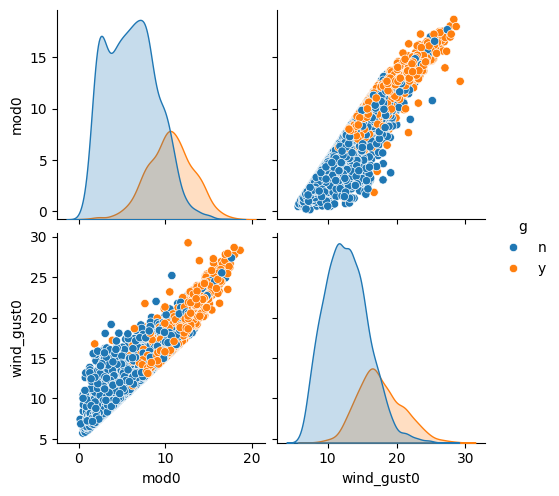

In [ ]:
sns.pairplot(win[win.dif_int>5][["mod0","wind_gust0","g"]],  hue='g',);

In [ ]:
win["wind_gust0"].describe()

count    41600.000000
mean         7.160643
std          4.428968
min          0.023710
25%          3.834732
50%          6.231800
75%          9.638942
max         29.232828
Name: wind_gust0, dtype: float64

In [ ]:
win["dif_int"].describe()

count    41600.000000
mean         2.508166
std          2.341852
min         -2.447657
25%          0.790846
50%          1.655715
75%          3.916108
max         16.575441
Name: dif_int, dtype: float64